In [ ]:
#%tensorflow_version 1.x
!pip install -q h5py==2.10.0
from scipy.io import loadmat
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


     |████████████████████████████████| 2.9 MB 5.3 MB/s 


In [ ]:
# load data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/ActivitiesFIR2(Signal_Selection)/data.mat")
print(D.keys())

dataC = D['dataC'][:,0:6]
tiltC = D['tiltC'].reshape((-1,1))
rollC = D['rollC'].reshape((-1,1))
aC_bt = D['aC_b_t'].reshape((-1,1))
aC_int = D['aC_in_t'].reshape((-1,1))
aC = D['aC'].reshape((-1,3))
dataR = D['dataR'][:,0:6]
tiltR = D['tiltR'].reshape((-1,1))
rollR = D['rollR'].reshape((-1,1))
dataL = D['dataL'][:,0:6]
tiltL = D['tiltL'].reshape((-1,1))
rollL = D['rollL'].reshape((-1,1))
dataTR = D['dataTR'][:,0:6]
tiltTR = D['tiltTL'].reshape((-1,1))
rollTR = D['rollTL'].reshape((-1,1))
dataTL = D['dataTL'][:,0:6]
tiltTL = D['tiltTL'].reshape((-1,1))
rollTL = D['rollTL'].reshape((-1,1))
des = D['des'][:,0]
num = des.shape[0]

dict_keys(['__header__', '__version__', '__globals__', 'aC', 'aC_b_t', 'aC_in_t', 'aL', 'aL_b_t', 'aL_in_t', 'aR', 'aR_b_t', 'aR_in_t', 'aTL', 'aTL_b_t', 'aTL_in_t', 'aTR', 'aTR_b_t', 'aTR_in_t', 'dataC', 'dataL', 'dataR', 'dataTL', 'dataTR', 'des', 'rollC', 'rollL', 'rollR', 'rollTL', 'rollTR', 'tiltC', 'tiltL', 'tiltR', 'tiltTL', 'tiltTR'])


In [ ]:
# APPEND Foot Data
data_app = np.append(dataC, tiltC, axis=1)
#data_app = np.append(data_app, rollC, axis=1)
data_app = np.append(data_app, aC, axis=1)
data_app = np.append(data_app, aC_bt, axis=1)
data_app = np.append(data_app, aC_int, axis=1)
#data_app = np.append(data_app, dataTR, axis=1)
#data_app = np.append(data_app, tiltTR, axis=1)

# Only Tilt Data

data_app = np.append(tiltC, tiltR, axis=1)
data_app = np.append(data_app, tiltL, axis=1)
data_app = np.append(data_app, tiltTR, axis=1)
data_app = np.append(data_app, tiltTL, axis=1)

In [ ]:
#PCA
# use PCA and choose suitable signals
#from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#data_app = sc.fit_transform(data_app)

#pca = PCA()
#data_app = pca.fit_transform(data_app)

#explained_variance = pca.explained_variance_ratio_
#print(explained_variance)

#from sklearn.decomposition import PCA

#pca = PCA(n_components=8)
#data_app = pca.fit_transform(data_app)


In [ ]:
N_TIME_STEPS = 100
step = 1
X = []
Y = []
for i in range(0, len(dataC) - N_TIME_STEPS, step):
    part = data_app[i: i + N_TIME_STEPS]
    label = stats.mode(des[i: i + N_TIME_STEPS])[0][0]
    X.append(part)
    Y.append(label)
Y_binary = to_categorical(Y)

# X = np.repeat(np.array(X),10, axis = 0)
# Y_binary = np.repeat(np.array(Y_binary),10, axis = 0)
# X = X[:,:,0:2]

In [ ]:
np.array(X).shape

(8783, 100, 5)

In [ ]:
np.array(Y_binary).shape

(8783, 10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_binary, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
    trainX = np.array(trainX)
    trainy = np.array(trainy)
    testX = np.array(testX)
    testy = np.array(testy)
    # define model
    verbose, epochs, batch_size = 1, 10, 20
    n_timesteps, n_features, n_outputs = np.array(trainX).shape[1], np.array(trainX).shape[2], np.array(trainy).shape[1]

    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 25
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return model,history,accuracy


In [ ]:
model,model_history,score = evaluate_model(X_train, y_train, X_test, y_test)

Epoch 1/10
236/236 [==============================] - 31s 105ms/step - loss: 0.4547 - accuracy: 0.8460 - val_loss: 0.1421 - val_accuracy: 0.9711
Epoch 2/10
236/236 [==============================] - 13s 54ms/step - loss: 0.0902 - accuracy: 0.9764 - val_loss: 0.0600 - val_accuracy: 0.9797
Epoch 3/10
236/236 [==============================] - 13s 55ms/step - loss: 0.0618 - accuracy: 0.9836 - val_loss: 0.0199 - val_accuracy: 0.9940
Epoch 4/10
236/236 [==============================] - 14s 60ms/step - loss: 0.0350 - accuracy: 0.9911 - val_loss: 0.0277 - val_accuracy: 0.9948
Epoch 5/10
236/236 [==============================] - 12s 52ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0227 - val_accuracy: 0.9944
Epoch 6/10
236/236 [==============================] - 13s 53ms/step - loss: 0.0395 - accuracy: 0.9898 - val_loss: 0.0192 - val_accuracy: 0.9948
Epoch 7/10
236/236 [==============================] - 12s 52ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0342 - val_accuracy

In [ ]:
print(score)

0.997723400592804


In [ ]:
#model.save('model_umn6')
#pickle.dump(model_history.history, open("history_umn6_2.p", "wb"))
#print("Saved model to disk")
#new_model = tf.keras.models.load_model('model_umn6')
#new_history = pickle.load(open("history_umn6_2.p", "rb"))
# Check its architecture
#new_model.summary()



In [ ]:
# reshape data into time steps of sub-sequences
X = np.array(X)
n_features, n_steps, n_length = X.shape[2], 4, 25
testX = X.reshape((X.shape[0], n_steps, 1, n_length, n_features))
Y_pred = model.predict(np.array(testX))
np.shape(Y_pred)

275/275 [==============================] - 6s 22ms/step


(8783, 10)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


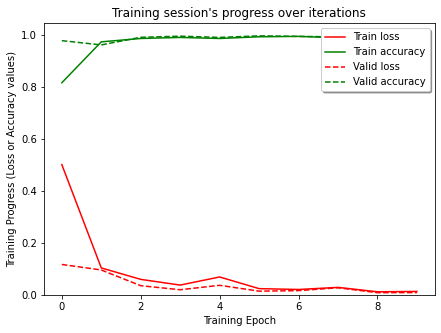

In [ ]:
print(model_history.history.keys())
plt.figure(figsize=(7, 5))
plt.plot(np.array(model_history.history['loss']), "r-", label="Train loss")
plt.plot(np.array(model_history.history['accuracy']), "g-", label="Train accuracy")
plt.plot(np.array(model_history.history['val_loss']), "r--", label="Valid loss")
plt.plot(np.array(model_history.history['val_accuracy']), "g--", label="Valid accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

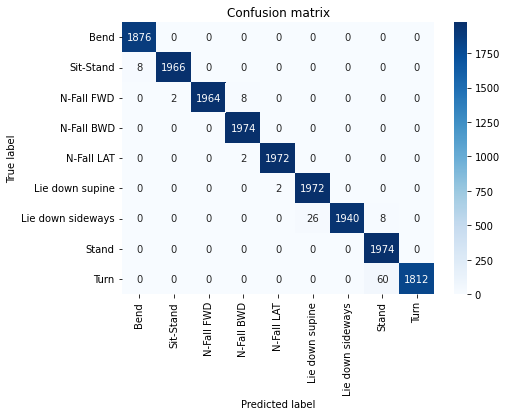

In [ ]:
LABELS = ['Bend','Sit-Stand','N-Fall FWD','N-Fall BWD','N-Fall LAT','Lie down supine','Lie down sideways','Stand','Turn']
Y_cat = np.argmax(Y_binary, axis=1)
Y_pred_cat = np.argmax(Y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(Y_cat, Y_pred_cat)
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix*2, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

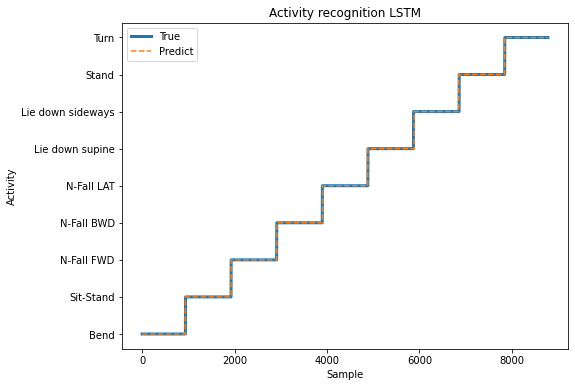

In [ ]:
def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(8, 6))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=3.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--')
    plt.yticks(np.arange(len(label_classes))+1, label_classes)
    plt.xlabel("Sample")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y)
t = np.arange(0,num*1,1)
visualize_activity_recognition(t, Y, Y_pred_cat, LABELS,"LSTM")

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y, Y_pred_cat)

0.997039735853353

In [ ]:
# train the second method
data_app2 = dataC

N_TIME_STEPS = 100
step = 1
X2 = []
Y2 = []
for i in range(0, len(dataC) - N_TIME_STEPS, step):
    part = data_app[i: i + N_TIME_STEPS]
    label = stats.mode(des[i: i + N_TIME_STEPS])[0][0]
    X2.append(part)
    Y2.append(label)
Y2_binary = to_categorical(Y2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2_binary, test_size=0.2, random_state=42)

def evaluate_model2(trainX, trainy, testX, testy):
    trainX = np.array(trainX)
    trainy = np.array(trainy)
    testX = np.array(testX)
    testy = np.array(testy)
    # define model
    verbose, epochs, batch_size = 1, 1, 11
    n_timesteps, n_features, n_outputs = np.array(trainX).shape[1], np.array(trainX).shape[2], np.array(trainy).shape[1]

    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 25
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return model,history,accuracy

model2,model_history2,score2 = evaluate_model2(X2_train, y2_train, X2_test, y2_test)

# reshape data into time steps of sub-sequences
X2 = np.array(X2)
n_features, n_steps, n_length = X2.shape[2], 4, 25
testX2 = X2.reshape((X2.shape[0], n_steps, 1, n_length, n_features))
Y2_pred = model2.predict(np.array(testX2))
np.shape(Y2_pred)
Y2_pred_cat = np.argmax(Y2_pred, axis=1)



275/275 [==============================] - 6s 19ms/step


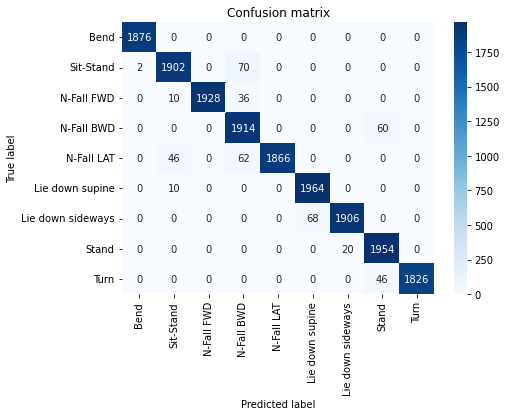

In [ ]:
LABELS = ['Bend','Sit-Stand','N-Fall FWD','N-Fall BWD','N-Fall LAT','Lie down supine','Lie down sideways','Stand','Turn']
confusion_matrix2 = metrics.confusion_matrix(Y_cat, Y2_pred_cat)
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix2*2, xticklabels=LABELS, annot=True, fmt="d", yticklabels=LABELS,cmap="Blues"); #show numbers:, annot=True, fmt="d"
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

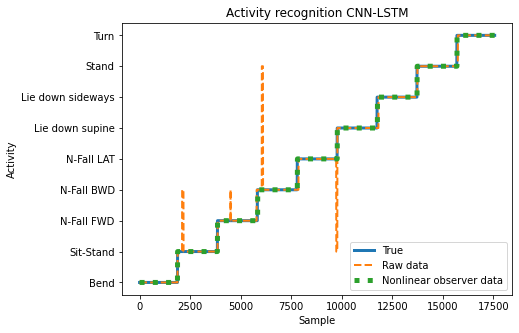

In [ ]:
def visualize_activity_recognition(t, label_true, label_pred1, label_pred2, label_classes,name):
    plt.figure(figsize=(7, 5))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=3.0)
    plt.plot(t.reshape(-1), label_pred1.reshape(-1), '--', linewidth=2.0)
    plt.plot(t.reshape(-1), label_pred2.reshape(-1), ':', linewidth=5.0)
    plt.yticks(np.arange(len(label_classes))+1, label_classes)
    plt.xlabel("Sample")
    plt.ylabel("Activity")
    plt.legend(["True", "Raw data", "Nonlinear observer data"])
    plt.show()

num = len(Y)
t = np.arange(0,num*1,1)*2
visualize_activity_recognition(t, Y, Y2_pred_cat, Y_pred_cat, LABELS,"CNN-LSTM")

In [ ]:
print(score2)

0.9709732532501221
